**Author:** Srikaran Elakurthy

**Description:**

The current algorithm trains a Neural network to predict a shot would become a scene boundary. This prediction is done by analysing the different movie shots. 

Horizontally stacked the Place,cast,audio and action features for each shot.

1.   Considering an even sliding window where we consider before and after shots for Each shot and all before shots as 1 channel and after shots as second channel. For Example if we are considering the window as 4 then for shot no:6 the first channel will shot data for 5,6 and second channel will have shot data for 7,8.
2. We are performing at channel level because each shot is considered as scene boundary or not, will be decided by analyzing before and after shots information. As the amount of priority given for before and after is equal. So we need to convolve exactly same for both. So we decide to make channels so that Convolution 2D performs same on both sides of a shot.
3. The model architecture is at the bottom of this ipynb file.
4.  Here we considered Focal Loss as our Loss function due to Class Imbalance dataset.


**Metrics:**
The best Miou we got0.42

"AP": 0.27538717329839113,

"mAP": 0.30240989906638455,

"Miou": 0.42189183857398244,

"Precision": 0.2486060100297133,

"Recall": 0.581917462249597,

"F1": 0.338406696537817





In [ ]:
pip install focal-loss

In [ ]:
import os
import sys
import glob
import json
import pickle
import torch
import tensorflow as tf
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from keras.layers.core import SpatialDropout1D
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Activation, Flatten
from keras.layers import MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical 
import random
import torch
from focal_loss import BinaryFocalLoss
from keras.models import Model


In [ ]:
#Load Train and test datasets and intializing window as 8
sourcefolder='/content/drive/MyDrive/eluvio/eluvio'
fd=open('{}/split_data/train_raw_data.pkl'.format(sourcefolder),'rb')
train_raw_data=pickle.load(fd)
fd.close()
fd=open('{}/split_data/test_raw_data.pkl'.format(sourcefolder),'rb')
test_raw_data=pickle.load(fd)
fd.close()
window=8

In [ ]:
#calculation for metrics
def calc_ap(gt_dict, pr_dict):
    """Average Precision (AP) for scene transitions.
    Args:
        gt_dict: Scene transition ground-truths.
        pr_dict: Scene transition predictions.
    Returns:
        AP, mean AP, and a dict of AP for each movie.
    """
    
    assert gt_dict.keys() == pr_dict.keys()
    
    AP_dict = dict()
    gt = list()
    pr = list()
    for imdb_id in gt_dict.keys():
        #print(imdb_id)
        AP_dict[imdb_id] = average_precision_score(gt_dict[imdb_id], pr_dict[imdb_id])
        gt.append(gt_dict[imdb_id])
        pr.append(pr_dict[imdb_id])

    mAP = sum(AP_dict.values()) / len(AP_dict)

    gt = np.concatenate(gt)
    pr = np.concatenate(pr)
    AP = average_precision_score(gt, pr)

    return AP, mAP, AP_dict


def calc_miou(gt_dict, pr_dict, shot_to_end_frame_dict, threshold=0.5):
    """Maximum IoU (Miou) for scene segmentation.
    Miou measures how well the predicted scenes and ground-truth scenes overlap. The descriptions can be found in
    https://arxiv.org/pdf/1510.08893.pdf. Note the length of intersection or union is measured by the number of frames.
    Args:
        gt_dict: Scene transition ground-truths.
        pr_dict: Scene transition predictions.
        shot_to_end_frame_dict: End frame index for each shot.
        threshold: A threshold to filter the predictions.
    Returns:
        Mean MIoU, and a dict of MIoU for each movie.
    """
    def iou(x, y):
        s0, e0 = x
        s1, e1 = y
        smin, smax = (s0, s1) if s1 > s0 else (s1, s0)
        emin, emax = (e0, e1) if e1 > e0 else (e1, e0)
        return (emin - smax + 1) / (emax - smin + 1)

    def scene_frame_ranges(scene_transitions, shot_to_end_frame):
        end_shots = np.where(scene_transitions)[0]
        scenes = np.zeros((len(end_shots) + 1, 2), dtype=end_shots.dtype)
        scenes[:-1, 1] = shot_to_end_frame[end_shots]
        scenes[-1, 1] = shot_to_end_frame[len(scene_transitions)]
        scenes[1:, 0] = scenes[:-1, 1] + 1
        return scenes

    def miou(gt_array, pr_array, shot_to_end_frame):
        gt_scenes = scene_frame_ranges(gt_array, shot_to_end_frame)
        pr_scenes = scene_frame_ranges(pr_array >= threshold, shot_to_end_frame)
        assert gt_scenes[-1, -1] == pr_scenes[-1, -1]

        m = gt_scenes.shape[0]
        n = pr_scenes.shape[0]

        # IoU for (gt_scene, pr_scene) pairs
        iou_table = np.zeros((m, n))

        j = 0
        for i in range(m):
            # j start prior to i end
            while pr_scenes[j, 0] <= gt_scenes[i, 1]:
                iou_table[i, j] = iou(gt_scenes[i], pr_scenes[j])
                if j < n - 1:
                    j += 1
                else:
                    break
            # j end prior to (i + 1) start
            if pr_scenes[j, 1] < gt_scenes[i, 1] + 1:
                break
            # j start later than (i + 1) start
            if pr_scenes[j, 0] > gt_scenes[i, 1] + 1:
                j -= 1
        assert np.isnan(iou_table).sum() == 0
        assert iou_table.min() >= 0

        # Miou
        return (iou_table.max(axis=0).mean() + iou_table.max(axis=1).mean()) / 2

    assert gt_dict.keys() == pr_dict.keys()

    miou_dict = dict()

    for imdb_id in gt_dict.keys():
        miou_dict[imdb_id] = miou(gt_dict[imdb_id], pr_dict[imdb_id], shot_to_end_frame_dict[imdb_id])
    mean_miou = sum(miou_dict.values()) / len(miou_dict)

    return mean_miou, miou_dict


def calc_precision_recall(gt_dict, pr_dict, threshold=0.5):
    """Precision, Recall and F1 for scene transitions at a given threshold.
    Args:
        gt_dict: Scene transition ground-truths.
        pr_dict: Scene transition predictions.
        threshold: A threshold to filter the predictions.
    Returns:
        Mean Precision, Recall, and F1, per IMDB ID Precisions, Recalls, and F1 scores.
    """
    def precision_recall(gt_array, pr_array):
        tp_fn = gt_array == 1
        tp_fp = pr_array >= threshold

        tps = (tp_fn & tp_fp).sum()

        precision = tps / tp_fp.sum()
        recall = tps / tp_fn.sum()

        return np.nan_to_num(precision), np.nan_to_num(recall)

    assert gt_dict.keys() == pr_dict.keys()

    precision_dict = dict()
    recall_dict = dict()
    fscore_dict = dict()

    for imdb_id in gt_dict.keys():
        p, r = precision_recall(gt_dict[imdb_id], pr_dict[imdb_id])
        precision_dict[imdb_id] = p
        recall_dict[imdb_id] = r
        fscore_dict[imdb_id] = 2 * p * r / (p + r)

    n = len(gt_dict)
    mean_precision = sum(precision_dict.values()) / n
    mean_recall = sum(recall_dict.values()) / n
    mean_fscore = sum(fscore_dict.values()) / n

    return mean_precision, mean_recall, mean_fscore, precision_dict, recall_dict, fscore_dict





In [ ]:
#Extracts shot level data from each movie and performs window operation 
#where each shot till left boundary is treated as one channel and the right boundary as another channel.
def preprocess_and_transform(window,movie_raw_data,train_data=True):
  """Extracts the shot information and stack the before and after shots to capture the clip level information.
    Args:
        window: Size of the sliding window .
        movie_raw_data: Movie data.
        train_data: (Boolean)If the movie raw data is a trian data or test data.
    Returns:
        Transformed shot level tensors and ground truths for each shots
    """
  left_padding_len=int((window-1)/2)
  right_padding_len=left_padding_len+1
  shot_level=[]
  movies=list(movie_raw_data.keys())
  ground_truth_lst=[]
  movie_level=dict()
  for movie_file in movies:
    shot_place_tensor=movie_raw_data[movie_file]['place'][:-1]
    shot_action_tensor=movie_raw_data[movie_file]['action'][:-1]
    shot_audio_tensor=movie_raw_data[movie_file]['audio'][:-1]
    shot_cast_tensor=movie_raw_data[movie_file]['cast'][:-1]
    shot_tensor=torch.hstack((shot_place_tensor,shot_action_tensor,shot_audio_tensor,shot_cast_tensor))
    ground_truth_lst.append(movie_raw_data[movie_file]['scene_transition_boundary_ground_truth'])
    shot_test=[]
    for t in range(0,shot_tensor.shape[0]):
      if (t==0) or ((t+right_padding_len)>(shot_tensor.shape[0]-1)) or ((t-left_padding_len)<0):
        if t==0:
          zerotensor = torch.zeros((left_padding_len,shot_tensor.shape[1]))
          temp=torch.vstack((zerotensor,shot_tensor[t]))
          shot=torch.vstack((temp,shot_tensor[t+1:t+right_padding_len+1]))
        elif t== (shot_tensor.shape[0]-1):
          zerotensor = torch.zeros((right_padding_len,shot_tensor.shape[1]))
          shot=torch.vstack((shot_tensor[t-left_padding_len:],zerotensor))
        elif (t+right_padding_len)>(shot_tensor.shape[0]-1):
          pad_len=(right_padding_len-((shot_tensor.shape[0]-1)-(t)))
          zerotensor = torch.zeros(pad_len,shot_tensor.shape[1])
          shot=torch.vstack((shot_tensor[(t-left_padding_len):(shot_tensor.shape[0])],zerotensor))
        elif (t-left_padding_len)<0:
          zerotensor = torch.zeros((left_padding_len-t,shot_tensor.shape[1]))
          temp=torch.vstack((zerotensor,shot_tensor[0:t+1]))
          shot=torch.vstack((temp,shot_tensor[t+1:t+right_padding_len+1]))
      else:
        shot=shot_tensor[t-left_padding_len:t+right_padding_len+1]
      if train_data==False:
        shot_test.append(shot)
      shot_level.append(shot)
    if train_data==False:
      test_shot_level=torch.stack(shot_test)
      movie_level[movie_file]={}
      movie_level[movie_file]['shot_tensor']=test_shot_level
      movie_level[movie_file]['ground_truth']=movie_raw_data[movie_file]['scene_transition_boundary_ground_truth']
      movie_level[movie_file]['shot_end_frame']=movie_raw_data[movie_file]['shot_end_frame']
  if train_data == True:
    shot_level=torch.stack(shot_level)
    ground_truth_tensor=torch.cat(ground_truth_lst)
    return shot_level,ground_truth_tensor
  else:
    return movie_level


In [ ]:
#transforms Test dataset into channel level and predicts whether a shot is a scene boundary or not.
def predict(test_movies,trained_model):
  """Takes the transformed testdata where shots are stacked with window operation and transforms to pytorch tensors 
  to the Tensorflow tensors and transform them to channels and predict scene boundaru for each shot
    Args:
        test_movies: transformed testdata where shots are stacked with window.
        trained_model: Model used for predicting the shot
        
    Returns:
        ground truths, predictions of each shot for movies and shot end frames for each movie. 
    """
  gt_dict = dict()
  pr_dict = dict()
  shot_to_end_frame_dict = dict()

  for test_mov in test_movies:
    test_X=test_movies[test_mov]['shot_tensor']
    test_Y=test_movies[test_mov]['ground_truth']
    test_X_np=test_X.numpy()
    test_X=tf.convert_to_tensor(test_X_np)
    #print(test_X.shape)
    test_X=tf.reshape(test_X,[test_X.shape[0],4,3584,2])
    y_pred=trained_model.predict(test_X)
    #print(y_pred.shape)
    
    gt_dict[test_mov] = test_Y
    pr_dict[test_mov] = torch.from_numpy(y_pred).flatten()
   

    shot_to_end_frame_dict[test_mov] = test_movies[test_mov]["shot_end_frame"]
  
  return gt_dict,pr_dict,shot_to_end_frame_dict

In [ ]:
#Preparing and transforming the train data to shot level with window as 8
train_X,train_Y=preprocess_and_transform(window,train_raw_data,train_data=True)


In [ ]:
#Converts Train Pytorch tensor to TensorFlow Tensor and labeling the ground truths
train_X_np=train_X.numpy()
train_Y_np=train_Y.numpy()
encoder = LabelEncoder()
encoder.fit(train_Y_np)
train_Y = encoder.transform(train_Y_np)
train_X=tf.convert_to_tensor(train_X_np)
train_Y=tf.convert_to_tensor(train_Y)


In [ ]:
#Transforming the test data
test_transform=preprocess_and_transform(window,test_raw_data,train_data=False)

In [ ]:
#transforming the train data into channel where first channel speaks the left shots and the second channel speaks the right channel
mod_train_X=tf.reshape(train_X,[train_X.shape[0],4,3584,2])

In [ ]:
#building the Neural Network Model using CNNs. Detailed description of architecture is provided at the end of the program. 
# Due toClass imbalance we are using Focal loss .
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model=Sequential()
#inputs = tf.keras.layers.Input(shape=mod_train_X.shape[1:])
model.add(tf.keras.layers.Conv2D(100,(int(window/2),4),padding='same',data_format='channels_last',activation='relu',input_shape=mod_train_X.shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),data_format='channels_last'))


model.add(tf.keras.layers.Conv2D(50,(2,2),padding='same',data_format='channels_last',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),data_format='channels_last'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(Flatten())
#model.add(Dense(500,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss=BinaryFocalLoss(pos_weight = 9, gamma = 2.5), optimizer='adam', metrics=['accuracy'])

In [ ]:
#Due to early Stopping and patience value set to 5 the epochs ended at 12
epochs = 100
batch_size = 128

history = model.fit(x=mod_train_X, y=train_Y, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[early_stopping])

In [ ]:
#saving the model
model.save("{}/final/shot_window_channel/shot_channel_win_8.2_nodense.h5".format(sourcefolder))

In [ ]:
#Loading the model
model_8_1=tf.keras.models.load_model("{}/final/shot_window_channel/shot_channel_win_8.2_nodense.h5".format(sourcefolder))

In [ ]:
#Predicting the shot is a scene boundary or not
gt_dict,pr_dict,shot_to_end_frame_dict=predict(test_transform,model_8_1)

In [ ]:
#Metrics
scores = dict()
scores["AP"], scores["mAP"], _ = calc_ap(gt_dict, pr_dict)
scores["Miou"], _ = calc_miou(gt_dict, pr_dict, shot_to_end_frame_dict)
scores["Precision"], scores["Recall"], scores["F1"], *_ = calc_precision_recall(gt_dict, pr_dict)

print("Scores:", json.dumps(scores, indent=4))

Scores: {
    "AP": 0.27538717329839113,
    "mAP": 0.30240989906638455,
    "Miou": 0.42189183857398244,
    "Precision": 0.2486060100297133,
    "Recall": 0.581917462249597,
    "F1": 0.338406696537817
}


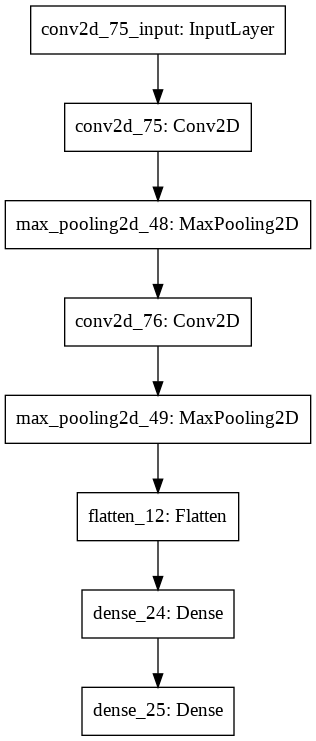

In [ ]:
from keras.utils import plot_model
plot_model(model_8_1, to_file='{}/final/shot_window_channel/shot_channel_win_8.2_nodense.png'.format(sourcefolder))

In [ ]:
model_8_1.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 4, 3584, 100)      3300      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 2, 1792, 100)      0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 2, 1792, 50)       20050     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 1, 896, 50)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 44800)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               4480100   
_________________________________________________________________
dense_25 (Dense)             (None, 1)               